In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from roc_plot import plot_ROC
from math import exp
%matplotlib inline

In [2]:
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

In [3]:
def load_data(path):
    train_data_ori = pd.read_excel(path, sheet_name='traindata', header=None)
    train_label = np.array(train_data_ori.iloc[:, -1])
    train_data = np.array(train_data_ori)[:, :-1]
    test_data_ori = pd.read_excel(path, sheet_name='testdata', header=None)
    test_label = np.array(test_data_ori.iloc[:, -1])
    test_data = np.array(test_data_ori)[:, :-1]
    
#     train_mean = train_data.mean(axis=0)
#     test_mean = test_data.mean(axis=0)
#     train_var = train_data.var(axis=0)
#     test_var = test_data.var(axis=0)
#     train_data = (train_data - train_mean) / train_var
#     test_data = (test_data - test_mean) / test_var
    
    train_min = train_data.min(axis=0)
    test_min = test_data.min(axis=0)
    train_max = train_data.max(axis=0)
    test_max = test_data.max(axis=0)
    train_data = (train_data + train_min) / (train_max - train_min)
    test_data = (test_data + test_min) / (test_max - test_min)
    train_data = train_data.T
    test_data = test_data.T
    return np.row_stack((train_data, np.ones(train_data.shape[1]))), \
           train_label.reshape((1,-1)), \
           np.row_stack((test_data, np.ones(test_data.shape[1]))), \
           test_label.reshape((1,-1))

In [4]:
train_data, train_label, test_data, test_label = load_data('PIDD.xlsx')

In [5]:
def initialize_zeros(dim):
    theta = np.zeros((dim, 1))
    return theta

In [6]:
def bp(theta, X, Y, C):
    m = X.shape[1]  # 获得样本总数
    A = sigmoid(np.dot(theta.T, X))
    cost = (-1 / m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
    dtheta = (1 / m) * (1 / C) * np.dot(X, (A - Y).T)

    cost = np.squeeze(cost)

    grads = {"dtheta": dtheta}

    return grads, cost

In [7]:
def optimize(theta, X, Y, iter_times, alpha, C, show_epoch = False):
    costs = []
    mini = 1
    for i in range(1, iter_times + 1):
        if iter_times % mini == 0:
            grads, cost = bp(theta, X, Y, C)
        dtheta = grads['dtheta']
        theta = theta - alpha * (1 / mini) * dtheta
        if i % (iter_times / 10) == 0:
            costs.append(cost)
        if show_epoch and i % (iter_times / 10) == 0:
            print("Cost after %6i epochs : %f" % (i, cost))  
            
    params = {"theta": theta}
    
    grads = {"dth": dtheta}
    
    return params, grads, costs

In [8]:
def predict(theta, X):
    m = X.shape[1]
    test_prediction = np.zeros((1, m))
    theta = theta.reshape(X.shape[0],1)
    test_score = sigmoid(np.dot(theta.T, X))
    for i in range(test_score.shape[1]):
        test_prediction[0, i] = 1 if test_score[0, i] > 0.5 else 0
        pass
    return test_prediction, test_score

In [9]:
def model(train_data, train_label, test_data, test_label, iter_times=10000, alpha=0.09, C=1.0, show_epoch = False):
    theta = initialize_zeros(train_data.shape[0])
    params, grads, costs = optimize(theta, train_data, train_label, iter_times, alpha, C, show_epoch)
    
    theta = params["theta"]
    
    train_prediction, train_score = predict(theta, train_data)
    test_predction, test_score = predict(theta, test_data)
    
    train_acc = 100 - np.mean(np.abs(train_prediction - train_label)) * 100
    test_acc = 100 - np.mean(np.abs(test_predction - test_label)) * 100

    print("train accuracy\t: %f" % train_acc)
    print("test accuracy\t: %f"%test_acc)

    d = {"costs": costs,
         "test_prediction": test_predction, 
         "train_prediction" : train_prediction, 
         "test_score" : test_score,
         "train_score" : train_score,
         "train_acc" : train_acc,
         "test_acc" : test_acc,
         "theta" : theta, 
         "learning_rate" : alpha,
         "num_iterations": iter_times}
    
    return d

In [10]:
d = model(train_data,  #训练集数据
          train_label, #训练集标签
          test_data,   #测试集数据
          test_label,  #测试集标签
          iter_times=1000,  #迭代次数
          alpha=0.005, #学习率
          C=0.005,  # 正则化系数
          show_epoch=True) # 是否显示迭代损失函数记录

Cost after    100 epochs : 0.560337
Cost after    200 epochs : 0.521270
Cost after    300 epochs : 0.501343
Cost after    400 epochs : 0.489588
Cost after    500 epochs : 0.482023
Cost after    600 epochs : 0.476879
Cost after    700 epochs : 0.473245
Cost after    800 epochs : 0.470605
Cost after    900 epochs : 0.468648
Cost after   1000 epochs : 0.467171
train accuracy	: 78.593750
test accuracy	: 71.875000


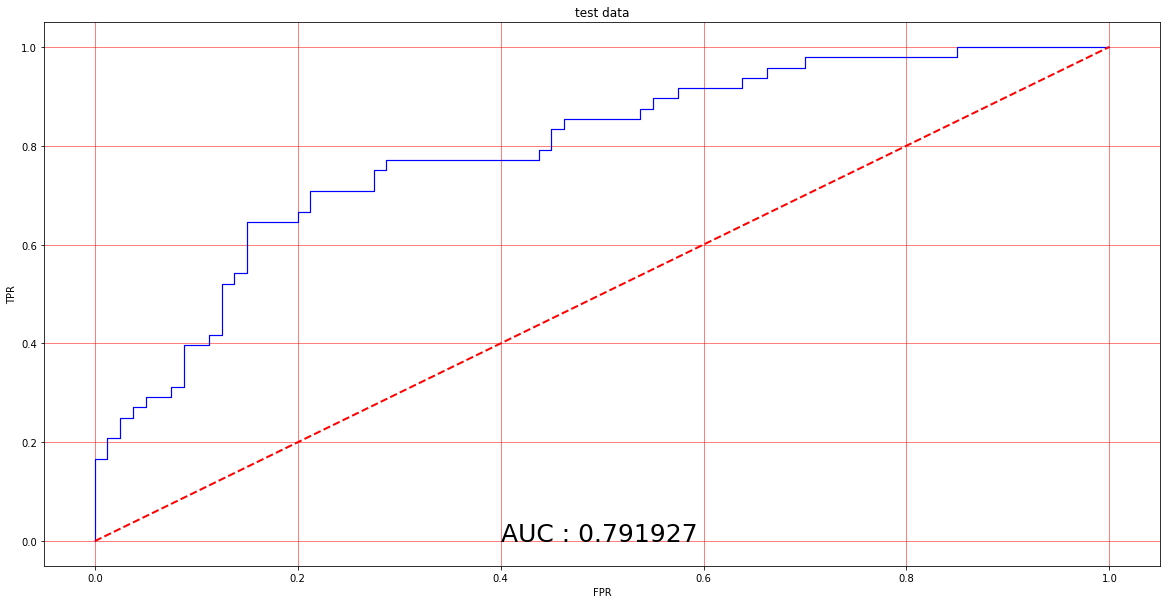

In [11]:
plot_ROC(d['test_score'].reshape((-1, 1)), test_label.reshape(-1, 1), 'test data')

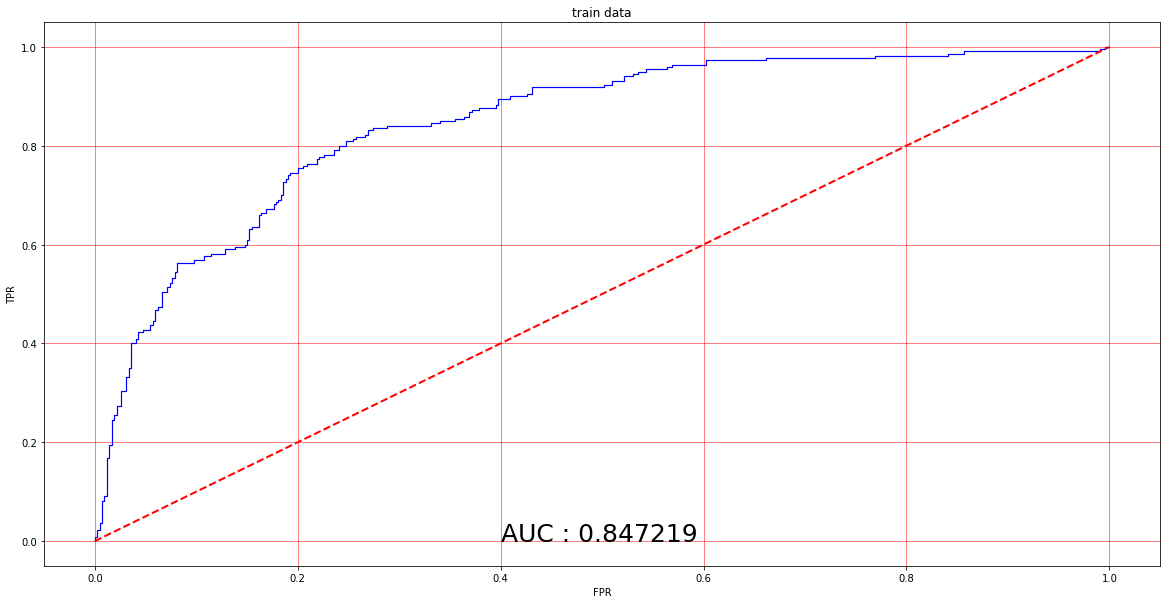

In [12]:
plot_ROC(d['train_score'].reshape((-1, 1)), train_label.reshape(-1, 1), "train data")